## 20 Newsgroups Dataset SHAP Explanations

### Install SHAP and Import Libraries

In [160]:
!pip install shap

In [161]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
import operator
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelpoma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Download 20news Data

In [162]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

The 20 newsgroups dataset was imported where the training and testing data were split as subsets of the 20 newsgroups dataset. The outcome variable was of two class names defined as ‘atheism’ and ‘christian’.

### Initialize and Fit tf-idf vectorizer

In [163]:
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)

y_train = newsgroups_train.target
y_test = newsgroups_test.target

The TF- IDF vectorizer defined the X train and X test variables by transforming text to feature vectors, which could then be used as inputs to the estimator. A min df value of 10 signifies that the word must occur in at least 10 documents to be considered a feature; else, it is dropped from the list of features. This helps to filter out any uncommon words.

### Train and Fit Classifier

In [164]:
sgd = SGDClassifier(loss="log", penalty="l2", max_iter=1000)
sgd.fit(X_train, y_train)

SGDClassifier(loss='log')

The loss parameter was set to log for the purpose of later calculating the difference in predicted probabilities between classes for each document. The max_iter parameter was set to 1000 as the maximum number of passes over the training data.

### Generate Confusion Matrix to Evaluate Accuracy of Classifier

In [165]:
from sklearn.metrics import confusion_matrix

print("Confusion Matrix\n", confusion_matrix(sgd.predict(X_test), y_test), "\n")

# Define each count
tn, fp, fn, tp = confusion_matrix(sgd.predict(X_test), y_test).ravel()
print("True  Neg:", tn, "   = Correct Christian")
print("False Pos:", fp, "    = Incorrect Atheist")
print("False Neg:", fn, "    = Incorrect Christian")
print("True  Pos:", tp, "   = Correct Atheist")

Confusion Matrix
 [[272  11]
 [ 47 387]] 

True  Neg: 272    = Correct Christian
False Pos: 11     = Incorrect Atheist
False Neg: 47     = Incorrect Christian
True  Pos: 387    = Correct Atheist


Correct Christian refers to Christian documents predicted Christian. Likewise, correct Atheist refers to Atheist documents predicted Atheist. Hence, incorrect Atheist refers to Atheist documents predicted Christian, while incorrect Christian refers to Christian documents predicted Atheist. For majority of the documents, the classifier predicted correctly, however most of the misclassified documents were Christian documents misclassified as Atheist.

### Initialize Explainer

In [166]:
# Initialize the explainer and apply to test data
explainer = shap.LinearExplainer(sgd, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

### Determine Number of Correct and Incorrect Classifications

In [167]:
correct_classifications = []
incorrect_classifications = []

for i in range(len(y_test)):
    if sgd.predict(X_test)[i] == y_test[i]:
        correct_classifications.append(i)
    else:
        incorrect_classifications.append(i)

print("# of Correct classifications   = ", len(correct_classifications))
print("# of Incorrect classifications = ", len(incorrect_classifications))

# of Correct classifications   =  659
# of Incorrect classifications =  58


In [168]:
X_test_array = X_test.toarray() # We need to provide the data in dense format, not sparse

### Visually Explain 5 documents Selected from the Test Set (3 Correct, 2 Incorrect)

- Feature values in pink caused increased predictions, while feature values in blue caused decreased predictions with their visual size shows the magnitude of the feature’s effect.

In [169]:
# CORRECTLY CLASSIFIED DOCUMENT
shap.initjs()
idx = correct_classifications[0]
print("Positive" if y_test[idx] else "Negative", "Review:")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Positive Review:
From: crackle!dabbott@munnari.oz.au (NAME)
Subject: "Why I am not Bertrand Russell" (2nd request)
Reply-To: dabbott@augean.eleceng.adelaide.edu.au (Derek Abbott)
Organization: Electrical & Electronic Eng., University of Adelaide
Lines: 4

Could the guy who wrote the article "Why I am not Bertrand Russell"
resend me a copy?

Sorry, I accidently deleted my copy and forgot your name.



In this we predicted 0.23, whereas the base value was 0.056. The biggest impacts came from the features “name”, “am”, “au”, “request”, and “guy” which were strongly positive.

In [170]:
# CORRECTLY CLASSIFIED DOCUMENT
shap.initjs()
idx = correct_classifications[1]
print("Positive" if y_test[idx] else "Negative", "Review:")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Negative Review:
From: madhaus@netcom.com (Maddi Hausmann)
Subject: Re: Amusing atheists and agnostics
Organization: Society for Putting Things on Top of Other Things
Lines: 26

timmbake@mcl.ucsb.edu ("Half" Bake Timmons) writes: >
Maddi: >>

>>Whirr click whirr...Frank O'Dwyer might also be contained
>>in that shell...pop stack to determine...whirr...click..whirr
>
>>"Killfile" Keith Allen Schneider = Frank "Closet Theist" O'Dwyer = ...

>= Maddi "The Mad Sound-O-Geek" Hausmann

No, no, no!  I've already been named by "Killfile" Keith.
My nickname is Maddi "Never a Useful Post" Hausmann, and
don't you DARE forget it, "Half".

>-- "...there's nothing higher, stronger, more wholesome and more useful in life
>than some good memory..." -- Alyosha in Brothers Karamazov (Dostoevsky)

You really should quote Ivan Karamazov instead(on a.a), as he was
the atheist.

-- 
Maddi Hausmann                       madhaus@netcom.com
Centigram Communications Corp        San Jose California  408/428-3553

In this we predicted -3.03, whereas the base value was 0.056. The biggest impacts came from the features “maddi” and “keith” which were strong positive.

In [171]:
# CORRECTLY CLASSIFIED DOCUMENT
shap.initjs()
idx = correct_classifications[2]
print("Positive" if y_test[idx] else "Negative", "Review:")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Positive Review:
From: mls@panix.com (Michael Siemon)
Subject: Re: homosexual issues in Christianity
Organization: Panix Public Access Internet & Unix, NYC
Lines: 164

In article <May.11.02.36.34.1993.28074@athos.rutgers.edu> mserv@mozart.cc.iup.edu (someone named Mark) writes:

>mls@panix.com (Michael Siemon) writes:
 
>>Homosexual Christians have indeed "checked out" these verses.  Some of
>>them are used against us only through incredibly perverse interpretations.
>>Others simply do not address the issues.

>I can see that some of the above verses do not clearly address the issues, 

There are exactly ZERO verses that "clearly" address the issues.

>however, a couple of them seem as though they do not require "incredibly 
>perverse interpretations" in order to be seen as condemning homosexuality.

The kind of interpretation I see as "incredibly perverse" is that applied
to the story of Sodom as if it were a blanket equation of homosexual
behavior and rape.  Since Christians citing t

In this we predicted 2.12, whereas the base value was 0.056. The biggest impacts came from the features “paul” and “christians” which were strongly positive.

In [172]:
# INCORRECTLY CLASSIFIED DOCUMENT
shap.initjs()
idx = incorrect_classifications[0]
print("Positive" if y_test[idx] else "Negative", "Review:")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Positive Review:
From: tdarcos@access.digex.net (Paul Robinson)
Subject: Homosexuality is Immoral (non-religious argument)
Organization: Tansin A. Darcos & Company, Silver Spring, MD USA
Lines: 43

[This was crossposted to a zillion groups.  I don't intend to
carry an entire discussion crossposted from alt.sex, particularly
one whose motivation seems to be having a fun argument.  However
I thought readers might be interested to know about the
discussion there.  --clh]

I intend to endeavor to make the argument that homosexuality is an
immoral practice or lifestyle or whatever you call it.  I intend to
show that there is a basis for a rational declaration of this
statement.  I intend to also show that such a declaration can be 
made without there being a religious justification for morality,
in fact to show that such a standard can be made if one is an atheist.

Anyone who wants to join in on the fun in taking the other side,
i.e. that they can make the claim that homosexuality is not i

In this we predicted 0.375, whereas the base value was 0.056. The biggest impacts came from the features “to”, “alt”, and “morality” which were strongly positive.

In [173]:
# INCORRECTLY CLASSIFIED DOCUMENT
shap.initjs()
idx = incorrect_classifications[1]
print("Positive" if y_test[idx] else "Negative", "Review:")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Negative Review:
From: aaron@minster.york.ac.uk
Subject: Re: Gulf War / Selling Arms
Distribution: world
Organization: Department of Computer Science, University of York, England
Lines: 14

Mark McCullough (mccullou@snake10.cs.wisc.edu) wrote:
: I heard about the arms sale to Saudi Arabia.  Now, how is it such a grave
: mistake to sell Saudi Arabia weapons?  Or are you claiming that we shouldn't
: sell any weapons to other countries?  Straightforward answer please.

Saudi Arabia is an oppressive regime that has been recently interfering
in the politcs of newly renunified Yemen, including assasinations and 
border incursions. It is entirely possible that they will soon invade.
Unluckily for Yemen it is not popular in the West as they managed to put
aside political differences during reunification and thus the West has
effectively lost one half (North?) as a client state.

		Aaron Turner
 



In this we predicted 0.25, whereas the base value was 0.056. The biggest impacts came from the features “york”, “aaron”, “west”, and “arabia” which were strongly positive.

### Compute the Accuracy of the Classifier and the Number of Misclassified Documents

In [174]:
# Accuracy of SGDClassifier
print("Accuracy of SGDClassifier =", sklearn.metrics.accuracy_score(sgd.predict(X_test), y_test), '\n')

# Number of Misclassified Documents
print("Number of Misclassified Documents =", len(incorrect_classifications))

Accuracy of SGDClassifier = 0.9191073919107392 

Number of Misclassified Documents = 58


The accuracy of the classifier was 0.91911. This indicates that the classifier was very accurate in classifying documents, but not perfect (1.0). Hence, this explains why there are some misclassified documents.

### Calculate Difference Between Probs of Two Predicted Classes (conf_i) for all Misclassified Documents 

In [175]:
mis_docs = [] # misclassified documents
mis_confs = [] # diff between probs of two predicted classes for misclassified documents
temp = []

for i in range(len(incorrect_classifications)):
    doc_num = incorrect_classifications[i]

    # Define
    doc_i = newsgroups_test.data[doc_num]
    conf_i = sgd.predict_proba(X_test[doc_num])[:,1] - sgd.predict_proba(X_test[doc_num])[:,0] # difference in prob of classes (christ - athe)

    mis_docs.append(doc_i)
    mis_confs.append(conf_i)

    temp.append(i+1)

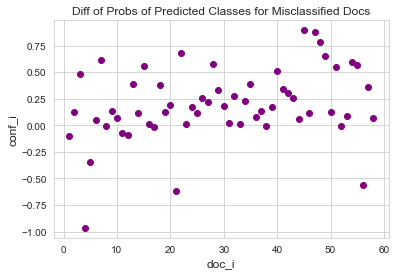

In [176]:
# Plot these differences
plt.title("Diff of Probs of Predicted Classes for Misclassified Docs")
plt.xlabel("doc_i", size=12)
plt.ylabel("conf_i", size=12)
plt.scatter(temp, mis_confs, color="purple")

The distribution seems somewhat uniform, with few outlying points. Probability differences are mostly clustered around near the 0.00 to 0.75 range. Positive conf i values indicate that the document was more likely predicted to be classified as Christian as opposed to Atheist. Hence, negative values indicate that the document was more likely predicted to be classified as Atheist as opposed to Christian. A difference of 0 indicates that the document was predicted to be classified the same for both outcomes.

### Identify Tokens (word_j) that Contributed to the Misclassification of Documents

In [177]:
mis_words = [] # words that contributed to misclassified documents

for i in range(len(incorrect_classifications)):
    doc_num = incorrect_classifications[i]

    idx = doc_num

    vals = shap_values[idx,:]
    sentiment_weight = defaultdict(float)
    feats = vectorizer.get_feature_names()

    for feat_i, val_i in zip(feats, vals):
      # Only consider negatives
      if val_i < 0:
        sentiment_weight[feat_i] += val_i

sent_list = list(sorted(sentiment_weight.items(), key=operator.itemgetter(1)))

for i in range(len(sent_list)):
    # Get word_j
    word_j = sent_list[i][0]
    mis_words.append(word_j)

print("Number of words contributing to misclassified documents:", len(mis_words))

Number of words contributing to misclassified documents: 1215


### Compute the Number of Documents (count_j) these Words Helped to Misclassify

In [178]:
mis_counts = [] # counts for number of documents word_j misclassified

# Iterate through each word
for i in range(len(mis_words)):
    word_j = mis_words[i]
    count_j = 0 # reset count

    # If, for each document, contains that word, increase count
    for j in range(len(mis_docs)):

        doc_num = incorrect_classifications[j]

        # If word_j is in document, add to count_j
        if word_j in newsgroups_test.data[doc_num]:
            count_j += 1

    mis_counts.append(count_j)

### Compute the Sum of Absolute SHAP Values (weight_j) for each word_j

In [179]:
mis_weights = [] # weights for each word_j

for i in range(len(incorrect_classifications)):
    doc_num = incorrect_classifications[i]

    idx = doc_num

    vals = shap_values[idx,:]
    sentiment_weight = defaultdict(float)
    feats = vectorizer.get_feature_names()

    for feat_i, val_i in zip(feats, vals):
        # Only consider negatives
        if val_i < 0:
            sentiment_weight[feat_i] += val_i

sent_list = list(sorted(sentiment_weight.items(), key=operator.itemgetter(1)))

for i in range(len(sent_list)):
    # Get absolute value of weight_j
    weight_j = abs(sent_list[i][1])
    mis_weights.append(weight_j)

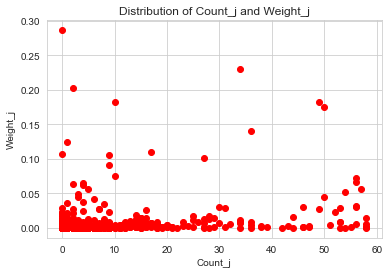

In [180]:
# Plot the distribution of count_j and weight_j
plt.title("Distribution of Count_j and Weight_j")
plt.xlabel("Count_j")
plt.ylabel("Weight_j")
plt.scatter(mis_counts, mis_weights, color="red")

The plot does not seem to follow a specific distribution, however most words that contributed to the misclassification of the documents were of minimal weight. This distribution is still valuable because it identifies how significant each word (token) was in contributing to the misclassification of the documents, and how many times it helped to misclassify.

### Identify Tokens with Highest Misclassification Weight

In [181]:
weights_des = sorted(mis_weights, reverse=True)
highest_words = []

print("Top 3 highest weights:", weights_des[0], ',', weights_des[1], ',', weights_des[2])

for i in range(len(mis_weights)):

  # Find index of specified weight in mis_weights list
  for j in range(3):
    if weights_des[j] == mis_weights[i]:
      # Find word corresponding to index
      highest_words.append(mis_words[i])

print("Token associated with highest weights:", highest_words[0], ',', highest_words[1], ',', highest_words[2])

Top 3 highest weights: 0.2860195239785701 , 0.23059500548173176 , 0.20249993604274485
Token associated with highest weights: newsreader , tin , freedom


## Chi-Square Filter Feature Selection

- Filter feature selection applies a statistical measure to each feature and assigns it a score. 
- These scores are then ranked, and are selected to be kept or removed from the dataset based on its score.
- This was a proper method of feature selection because we are dealing with categorical inputs (predictors) and categorical outputs (outcome), as opposed to numerical data.

### Implement Feature Selection Strategy

In [182]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Define feature selection
fs = SelectKBest(score_func=chi2, k='all')

# Apply feature selection to train set
X_selected_train = fs.fit_transform(X_train, y_train)
print(X_selected_train.shape)

# Apply feature selection to test set
X_selected_test = fs.fit_transform(X_test, y_test)
print(X_selected_test.shape)

(1079, 2902)
(717, 2902)


### Train and Fit the Classifier after Feature Selection

In [183]:
sgd = SGDClassifier(loss="log", penalty="l2", max_iter=1000)
sgd.fit(X_selected_train, y_train)

SGDClassifier(loss='log')

### Generate Confusion Matrix after Feature Selection

In [184]:
print("Confusion Matrix\n", confusion_matrix(sgd.predict(X_selected_test), y_test), "\n")

# Define each count
tn, fp, fn, tp = confusion_matrix(sgd.predict(X_selected_test), y_test).ravel()
print("True  Neg:", tn, "   = Correct Christian")
print("False Pos:", fp, "     = Incorrect Atheist")
print("False Neg:", fn, "   = Incorrect Christian")
print("True  Pos:", tp, "   = Correct Atheist")

Confusion Matrix
 [[271   7]
 [ 48 391]] 

True  Neg: 271    = Correct Christian
False Pos: 7      = Incorrect Atheist
False Neg: 48    = Incorrect Christian
True  Pos: 391    = Correct Atheist


The classifier predictions were very similar to before, but differ.

### Initialize the Explainer and Apply to Test Data after Feature Selection

In [185]:
explainer = shap.LinearExplainer(sgd, X_selected_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_selected_test)

### Seperate Correctly and Incorrectly Classified Documents

In [186]:
correct_classifications_FS = []
incorrect_classifications_FS = []

for i in range(len(y_test)):
    if sgd.predict(X_selected_test)[i] == y_test[i]:
        correct_classifications_FS.append(i)
    else:
        incorrect_classifications_FS.append(i)

print("# of Correct classifications after Feature Selection   = ", len(correct_classifications_FS))
print("# of Incorrect classifications after Feature Selection = ", len(incorrect_classifications_FS))

# of Correct classifications after Feature Selection   =  662
# of Incorrect classifications after Feature Selection =  55


### Compute Accuracy of the Classifier and the Number of Misclassified Documents after Feature Selection

In [187]:
# Accuracy of SGDClassifier
print("Accuracy of SGDClassifier =", sklearn.metrics.accuracy_score(sgd.predict(X_selected_test), y_test), '\n')

# Number of Misclassified Documents
print("Number of Misclassified Documents =", len(incorrect_classifications_FS))

Accuracy of SGDClassifier = 0.9232914923291492 

Number of Misclassified Documents = 55


after feature selection, the SGDClassifier classifier was more accurate than before. It had an accuracy score of 0.92469, as opposed to 0.91911 before (roughly a 1 percent increase). there were now less misclassified documents after feature selection, as opposed to before.

In [188]:
# See which documents were misclassified before, and are not classified correctly

correct_after_FS = []

# Check misclassifications before. (if in incorrect_classifications AND in correct_classifications_FS (WORKED!)
# Iterate through misclassified docs before feature selection
for i in range(len(incorrect_classifications)):

  # If misclassified before, and correctly classified now, append
  if incorrect_classifications[i] in correct_classifications_FS:
    correct_after_FS.append(incorrect_classifications[i])

In [189]:
X_selected_test_array = X_selected_test.toarray() # We need to provide the data in dense format, not sparse

In [190]:
# Identify at least one example that was misclassified before feature selection and that is classified correctly after feature selection
# Use second to last document that was misclassified before FS, but not classified correctly
shap.initjs()
idx = correct_after_FS[-2]
print("Positive" if y_test[idx] else "Negative", "Review:")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Positive Review:
From: kilroy@gboro.rowan.edu (Dr Nancy's Sweetie)
Subject: Does Anyone Remember . . .
Organization: Rowan College of New Jersey
Lines: 30

Some years ago -- possibly as many as five -- there was a discussion on
numerology.  (That's where you assign numeric values to letters and then add
up the letters in words, in an effort to prove something or another.  I can
never make any sense of how it's supposed to work or what it's supposed to
prove.)

Somebody posted a long article about numerology in the Bible, saying
things like "this proves the intricate planning of the Scriptures, else
these patterns would not appear".

Then there was a brilliant followup, which was about numerology in all the
other numerology posts.  Stuff like "The word `numerology' adds up to 28,
and the word appears 28 times in the posting!  Such elegant planning!
Further, the word `truth' ALSO adds up to 28; the writer is using these
numerological clues to show us that we reach truth via numerology!"


In [191]:
# Use last document that was misclassified before FS, but not classified correctly
shap.initjs()
idx = correct_after_FS[-1]
print("Positive" if y_test[idx] else "Negative", "Review:")
print(newsgroups_test.data[idx])
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names()
)

Positive Review:
From: mserv@mozart.cc.iup.edu (Mail Server)
Subject: Re: Dreams and out of body incidents
Lines: 19

dt4%cs@hub.ucsb.edu (David E. Goggin) writes:

>1) Dreams and OOBEs are totally mental phenomena.  In this case no morality
...
>2) Dreams and OOBEs have a reality of their own (i.e. are 'another plane')
...
>3) Like (2), but here we assume that though the dreeam and OOBE environs have 
>a
>real existence, a different moral/ethics apply there, and no (or maybe 
>different) moral laws apply there.


I can think of another alternative:

4)  OOBE's are a form of contact with the demonic world, whereby one 
intentionally or unintentionally surrenders control of his or her perceptions 
to spiritual beings whose purpose is to deceive and entrap them.

- Mark

